# Simulation 
 
  
  

In [1]:
import numpy as np
np.random.seed(1)
from __future__ import print_function, division
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing
from scipy.linalg import expm,logm
import scipy as sp   ##在numpy基础上实现的部分算法库
from scipy.optimize import leastsq  ##引入最小二乘法算法

## 1、生成Simulation中的各个unit对应的signa

In [2]:
#生成随机数
mean=[-1,5,-1,5,1,-5,-1,5]
cov=[[900,1,0,0,0,0,0,0],
     [1,2,0,0,0,0,0,0],
     [0,0,900,1,0,0,0,0],
     [0,0,1,2,0,0,0,0],
     [0,0,0,0,900,1,0,0],
     [0,0,0,0,1,2,0,0],
     [0,0,0,0,0,0,900,1],
     [0,0,0,0,0,0,1,2]]
r=np.random.multivariate_normal(mean,cov,3)    #生成3个大写的Gamma

In [3]:
#生成潜在路径和检测
D1=np.zeros((4,150))     #生成3个零矩阵，对应的是unit(i)的各个信号
D2=np.zeros((4,150)) 
D3=np.zeros((4,150)) 
for t in range(0,149):   #取时间为0:149，各个unit的潜在路径
    D1[0][t]=r[0][0]+r[0][1]*(0.2*t+math.sin(0.2*t))
    D1[1][t]=r[0][2]+r[0][3]*(0.6*(t**0.8)-100/(t+5))
    D1[2][t]=r[0][4]+r[0][5]*((t**1.4)/40)
    D1[3][t]=r[0][6]+r[0][7]*((t**1.6)/100+3*math.cos(0.1*t))
    D2[0][t]=r[1][0]+r[1][1]*(0.2*t+math.sin(0.2*t))
    D2[1][t]=r[1][2]+r[1][3]*(0.6*(t**0.8)-100/(t+5))
    D2[2][t]=r[1][4]+r[1][5]*((t**1.4)/40)
    D2[3][t]=r[1][6]+r[1][7]*((t**1.6)/100+3*math.cos(0.1*t)) 
    D3[0][t]=r[2][0]+r[2][1]*(0.2*t+math.sin(0.2*t))
    D3[1][t]=r[2][2]+r[2][3]*(0.6*(t**0.8)-100/(t+5))
    D3[2][t]=r[2][4]+r[2][5]*((t**1.4)/40)
    D3[3][t]=r[2][6]+r[2][7]*((t**1.6)/100+3*math.cos(0.1*t))
ERR1=np.random.normal(loc=0,scale=10,size=(4,150))
ERR2=np.random.normal(loc=0,scale=10,size=(4,150))
ERR3=np.random.normal(loc=0,scale=10,size=(4,150))    
L1=D1+ERR1
L2=D2+ERR2
L3=D3+ERR3

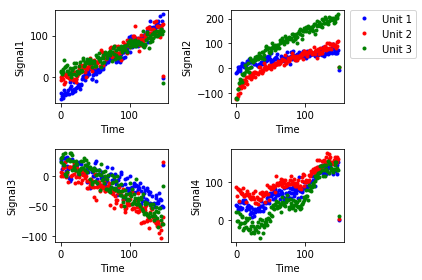

In [4]:
#绘制监测数据
plt.figure(1)
ax1=plt.subplot(221)    #绘制子图
plt.xlabel('Time')      #绘制横纵坐标
plt.ylabel('Signal1')
plt.plot(L1[0],'b.')
plt.plot(L2[0],'r.')          
plt.plot(L3[0],'g.')
ax2=plt.subplot(222)
plt.xlabel('Time')
plt.ylabel('Signal2')
plt.plot(L1[1],'b.',label="Unit 1")
plt.plot(L2[1],'r.',label="Unit 2")          
plt.plot(L3[1],'g.',label="Unit 3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax3=plt.subplot(223)
plt.xlabel('Time')
plt.ylabel('Signal3')
plt.plot(L1[2],'b.')
plt.plot(L2[2],'r.')          
plt.plot(L3[2],'g.')
ax4=plt.subplot(224)
plt.xlabel('Time')
plt.ylabel('Signal4')
plt.plot(L1[3],'b.')
plt.plot(L2[3],'r.')          
plt.plot(L3[3],'g.')
plt.tight_layout()   #调节子图距离

## 2、进行简单的分析，方便理解

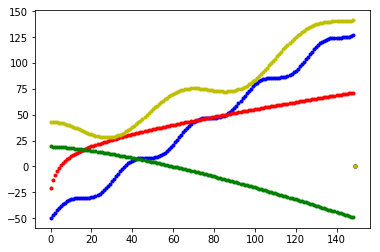

In [5]:
#就Unit 1为例进行RUL估计

#潜在路径图
plt.plot(D1[0],'b.')
plt.plot(D1[1],'r.')          
plt.plot(D1[2],'g.')
plt.plot(D1[3],'y.')

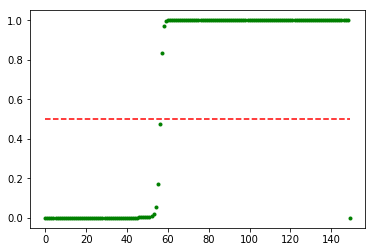

In [6]:
#绘图P（Ti<=t)
P=np.zeros((1,150)) 
for t in range(0,149):   #取时间为0:149，各个unit的潜在路径
    P[0][t]=1/(math.exp(15-D1[0][t]-0.05*D1[1][t]+0.2*D1[2][t])+1)
plt.plot(P[0],'g.')
plt.plot([0,149],[0.5,0.5],'r--')

In [7]:
#给出具体的时间点
t=0
while P[0][t]<0.5:
    t=t+1
print (t)    #输出失效的时间（整数点）

57


# Application

$\qquad$  
* 主要分为两个大部分：
         
         
* 1、新方法与Song(2018)的HI法进行一个对比（选择11个sensors考虑问题：T24、T50、P30、Nf、Ps30、phi、NRf、BPR、htBleed、W31和W32）； 
     
     
* 2、使用该新方法对传感器进行选择，与基准测试方法（brenchmark methods）得到的结果（Fang(2017)和Song(2018)）进行对比。 
 


## 1、读入文件  

$\qquad$  
* 本次使用的是FD001相关文件。此处按照文章要求完全按照Song(2018)进行处理。即选定指定的sensors。

In [8]:
#读入文件
testdata=pd.read_csv('test_FD001.txt',sep=" ",header=None)   
traindata=pd.read_csv('train_FD001.txt',sep=" ",header=None)   
RULdata=pd.read_csv('RUL_FD001.txt',sep=" ",header=None)   
print(RULdata.shape)    #查看矩阵大小
print(testdata.shape)    
print(traindata.shape)  
testdata.drop(testdata.columns[[26,27]],axis=1,inplace=True)    #删除文件载入时多读的列数
traindata.drop(traindata.columns[[26,27]],axis=1,inplace=True)
RULdata.drop(RULdata.columns[1],axis=1,inplace=True)

#列名称重命名
testdata=testdata.rename(columns={0:'unit number',1:'time',2:'operational setting 1',3:'operational setting 2',4:'operational setting 3',5:'T2',6:'T24',7:'T30',8:'T50',9:'P2',10:'P15',11:'P30',12:'Nf',13:'Nc',14:'epr',15:'Ps30',16:'phi',17:'NRf',18:'NRc',19:'BPR',20:'farB',21:'htBleed',22:'Nf_dmd',23:'PCNfR_dmd',24:'W31',25:'W32'})
traindata=traindata.rename(columns={0:'unit number',1:'time',2:'operational setting 1',3:'operational setting 2',4:'operational setting 3',5:'T2',6:'T24',7:'T30',8:'T50',9:'P2',10:'P15',11:'P30',12:'Nf',13:'Nc',14:'epr',15:'Ps30',16:'phi',17:'NRf',18:'NRc',19:'BPR',20:'farB',21:'htBleed',22:'Nf_dmd',23:'PCNfR_dmd',24:'W31',25:'W32'})

#选择指定的sensors
testdata.drop(testdata.columns[[2,3,4,5,7,9,10,13,14,18,20,22,23]],axis=1,inplace=True)
traindata.drop(traindata.columns[[2,3,4,5,7,9,10,13,14,18,20,22,23]],axis=1,inplace=True)

(100, 2)
(13096, 28)
(20631, 28)


## 2、数据预处理   

$\qquad$  
* 对于信号进行对数处理&标准化处理。

In [9]:
#对信号进行对数处理
testdata1=testdata
traindata1=traindata
testdata1=testdata1.apply(np.log) #对于unit number不需要进行对数处理且不需要进行标准化，由于后期对该变量进行替换，因此在此处不进行多余的操作
traindata1=traindata1.apply(np.log)
RULdata=RULdata.apply(np.log)

In [10]:
#使用了z-score的归一化处理手法
testdata2=testdata1
traindata2=traindata1
testdata2=testdata2.apply(lambda x:(x-np.mean(x))/np.std(x,ddof=1))  #进行标准化
testdata2['unit number']=testdata['unit number'] 
traindata2=traindata2.apply(lambda x:(x-np.mean(x))/np.std(x,ddof=1))  #进行标准化
traindata2['unit number']=traindata['unit number']

## 3、潜在路径

$\qquad$  
* 此次采用的是二次退化模型，使用了前人所研究的认为贴近退化过程的模型$\eta_j(t,\Gamma_{i,j})=[1,t,t^2]\Gamma_{i,j}$，其中，$\Gamma_{i,j} \sim N(\mu_j,\Sigma_j)$,$\varepsilon_{i,j} \sim N(0,\sigma_{j}^2)$。需要对每个传感器都进行如上操作，即对每个$j$都要进行该操作。  
      
        
* 其中$\mu_j$和$\Sigma_j$使用Lu(1993)论文中的方法进行估计。

### （1）理论知识：$\mu_j$、$\varepsilon_j$和$\Sigma_j$的估计原理

* 需要注意，由于框架论文与细节论文中的设定不同，所以一些内容需要进行逻辑转换。  

设定模型为：  
$$
\begin{cases}
y_{i,j}=\eta_{i,j}+\varepsilon_{i,j}=\eta(t_j;\Phi,\Theta_i)+\varepsilon_{i,j} \\
\varepsilon_{i,j} \sim N(0,\sigma_{\varepsilon}^2)
\end{cases}$$  
其中$\Phi$表示的是对于所有的$i$相同的固定效应参数，$\Theta_i$表示的是对于每个$i$的随机效应参数，$\sigma_{\varepsilon}$是一个恒定的常数（这也就是在实战中需要单独对于每个$j$进行建模的原因）。     
  
  
 ① 设定$H(\Theta_i)=\pmb{\theta_i}=(\theta_{1i},\theta_{2i},…,\theta_{p_{\theta}}$$_i) \sim N_n(\pmb{\mu}_\theta,\pmb{\Sigma}_\theta)$ &ensp; $(i=1,2,…,n)$。使用最小二乘法去估计$\pmb{\mu}_\theta$，目标函数为$min \mathcal{L}=\sum_{j=1}^{m_i}[y_{ij}-\eta(t_j;\varphi,\vartheta)]^2$，$\pmb{\mu}_\theta$为前面分组估计的平均值。 
    
 ② 用式子$\hat{\sigma}^2_{\varepsilon i}=\frac{1}{m_{\Theta i}-p}\mathcal{L}(\hat{\Phi}_i,\hat{\Theta}_i)$去估计$\hat{\sigma}^2_{\varepsilon}$，其中$p$为$\Phi$和$\Theta$的维数和。  
  
 ③ 用式子$\hat{\pmb{\Sigma}}_\theta=\frac{1}{n-1}\sum_{i=1}^{n}(\hat{\pmb{\theta}}_i-\hat{\pmb{\mu}}_{\theta})(\hat{\pmb{\theta}}_i-\hat{\pmb{\mu}}_{\theta})'-\frac{1}{n}\sum_{i=1}^{n}\hat{var}_\varepsilon(\hat{\pmb{\theta}}_i)$  去估计$\hat{\pmb{\Sigma}}_\theta$。$\hat{var}_\varepsilon(\hat{\pmb{\theta}}_i)$在这里指的是在已知 $\hat{\Phi}_i$、$\hat{\Theta}_i$ 和 $\hat{\pmb{\sigma}}_{\varepsilon i}$ 的情况下计算出的$var_\sigma(\hat{\pmb{\theta}}_i)$。其中$var_\sigma(\hat{\pmb{\theta}}_i)=\sigma_\varepsilon^2[\pmb{\dot{\eta}'}(\pmb{t_i;\Phi,\Theta_i})*\pmb{\dot{\eta}}(\pmb{t_i;\Phi,\Theta_i})]^{p_\theta    p_\theta}$。 
  
  $\pmb{\dot{\eta}}(\pmb{t_i;\Phi,\Theta_i})=(\eta(t_1;\Phi,\Theta_i),\eta(t_2;\Phi,\Theta_i),…，\eta(t_{m_i};\Phi,\Theta_i))$；$\pmb{\dot{\eta}'}(\pmb{t_i;\Phi,\Theta_i})=\frac{\partial \pmb{\eta}(\pmb{t_i;\phi,\theta_i})}{\partial (\pmb{\Phi'\theta_i'})}|_{(\phi,\theta)=(\Phi,\Theta_i)}$；$[\pmb{\dot{\eta}'}(\pmb{t_i;\Phi,\Theta_i})*\pmb{\dot{\eta}}(\pmb{t_i;\Phi,\Theta_i})]^{p_\theta    p_\theta}$为$[\pmb{\dot{\eta}'}(\pmb{t_i;\Phi,\Theta_i})*\pmb{\dot{\eta}}(\pmb{t_i;\Phi,\Theta_i})]^{-1}$右下方的$p_\theta * p_\theta$ 子矩阵。
    
    
在之后的操作过程中，为了方便说明，记$M_a=\frac{1}{n-1}\sum_{i=1}^{n}(\hat{\pmb{\theta}}_i-\hat{\pmb{\mu}}_{\theta})(\hat{\pmb{\theta}}_i-\hat{\pmb{\mu}}_{\theta})'$，$M_b=\frac{1}{n}\sum_{i=1}^{n}\hat{var}_\varepsilon(\hat{\pmb{\theta}}_i)$。


### （2）实战

####  ① 估计各个$\mu_j$。

In [11]:
unit=traindata2['unit number']
number=np.zeros(100)
for i in range(100):
    for j in range(unit.size):
        if unit[j]==i+1:
            number[i]=number[i]+1
print(number)        #求出各组i所对应的个数

[192. 287. 179. 189. 269. 188. 259. 150. 201. 222. 240. 170. 163. 180.
 207. 209. 276. 195. 158. 234. 195. 202. 168. 147. 230. 199. 156. 165.
 163. 194. 234. 191. 200. 195. 181. 158. 170. 194. 128. 188. 216. 196.
 207. 192. 158. 256. 214. 231. 215. 198. 213. 213. 195. 257. 193. 275.
 137. 147. 231. 172. 185. 180. 174. 283. 153. 202. 313. 199. 362. 137.
 208. 213. 213. 166. 229. 210. 154. 231. 199. 185. 240. 214. 293. 267.
 188. 278. 178. 213. 217. 154. 135. 341. 155. 258. 283. 336. 202. 156.
 185. 200.]


In [12]:
miu=np.zeros((3,11))     #存储所得到的miu

#需要拟合的函数func :指定函数的形状
def func(p,t):
    a,b,c=p
    return a*t*t+b*t+c

#偏差函数：x,y都是列表
def error(p,t,y):
    return func(p,t)-y 

p0=[1,1,1]    #设定初值
train=np.array(traindata2)

#T24的参数
miu_T24=np.zeros((3,100))     #存储每次计算得到的miu_ij，之后在计算sigma2的时候还需要使用
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    T24_i=train[qs:ending,2]
    CS=leastsq(error,p0,args=(time_i,T24_i))
    miu_T24[:,i]=CS[0]     #得到T24的最小二乘的相关参数
miu[:,0]=np.mean(miu_T24,axis=1)

#T50的参数
miu_T50=np.zeros((3,100)) 
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    T50_i=train[qs:ending,3]
    CS=leastsq(error,p0,args=(time_i,T50_i))
    miu_T50[:,i]=CS[0]     
miu[:,1]=np.mean(miu_T50,axis=1)

#P30的参数
miu_P30=np.zeros((3,100)) 
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    P30_i=train[qs:ending,4]
    CS=leastsq(error,p0,args=(time_i,P30_i))
    miu_P30[:,i]=CS[0]     
miu[:,2]=np.mean(miu_P30,axis=1)

#Nf的参数
miu_Nf=np.zeros((3,100)) 
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    Nf_i=train[qs:ending,5]
    CS=leastsq(error,p0,args=(time_i,Nf_i))
    miu_Nf[:,i]=CS[0]     
miu[:,3]=np.mean(miu_Nf,axis=1)

#Ps30的参数
miu_Ps30=np.zeros((3,100)) 
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    Ps30_i=train[qs:ending,6]
    CS=leastsq(error,p0,args=(time_i,Ps30_i))
    miu_Ps30[:,i]=CS[0]     
miu[:,4]=np.mean(miu_Ps30,axis=1)

#phi的参数
miu_phi=np.zeros((3,100)) 
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    phi_i=train[qs:ending,7]
    CS=leastsq(error,p0,args=(time_i,phi_i))
    miu_phi[:,i]=CS[0]     
miu[:,5]=np.mean(miu_phi,axis=1)

#NRf的参数
miu_NRf=np.zeros((3,100))
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    NRf_i=train[qs:ending,8]
    CS=leastsq(error,p0,args=(time_i,NRf_i))
    miu_NRf[:,i]=CS[0]     
miu[:,6]=np.mean(miu_NRf,axis=1)

#BPR的参数
miu_BPR=np.zeros((3,100))
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    BPR_i=train[qs:ending,9]
    CS=leastsq(error,p0,args=(time_i,BPR_i))
    miu_BPR[:,i]=CS[0]     
miu[:,7]=np.mean(miu_BPR,axis=1)

#htBleed的参数
miu_htBleed=np.zeros((3,100))
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    htBleed_i=train[qs:ending,10]
    CS=leastsq(error,p0,args=(time_i,htBleed_i))
    miu_htBleed[:,i]=CS[0]     
miu[:,8]=np.mean(miu_htBleed,axis=1)

#W31的参数
miu_W31=np.zeros((3,100))
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    W31_i=train[qs:ending,11]
    CS=leastsq(error,p0,args=(time_i,W31_i))
    miu_W31[:,i]=CS[0]     
miu[:,9]=np.mean(miu_W31,axis=1)

#W32的参数
miu_W32=np.zeros((3,100))
for i in range(100):
    qs=0
    for ii in range(i):
        qs=int(qs+number[ii])
    ending=int(qs+number[i])      #设定结束点
    time_i=train[qs:ending,1]
    W32_i=train[qs:ending,12]
    CS=leastsq(error,p0,args=(time_i,W32_i))
    miu_W32[:,i]=CS[0]     
miu[:,10]=np.mean(miu_W32,axis=1)

print(miu)     #输出各个μj

[[ 0.25186554  0.27891589 -0.26983456  0.23022275  0.28501384 -0.27772425
   0.22809972  0.26749639  0.25026103 -0.25987623 -0.26059466]
 [ 0.91369698  1.02162212 -0.98824385  0.84247553  1.0457877  -1.0149355
   0.84209731  0.96864722  0.91150472 -0.95471383 -0.95587904]
 [-0.16692669 -0.18920941  0.1769868  -0.12630948 -0.18987897  0.18179866
  -0.12532226 -0.18158101 -0.17865442  0.17677726  0.17902009]]


####  ② 估计各个$\varepsilon_j^2$。 

本次应用中没有固定效应参数，仅有随机效应参数，故$p=3$,一共有20631组数据。

In [13]:
sigma2=np.zeros(11)    #设定存放的时间t
time=train[:,1]
ll=time      #由于无法通过np.zeros设定这么大的向量，由此选择使用替代法一一进行替代
n=time.size
for i in range(n):
    ll[i]=0          #设定一个矩阵存放理论得到的T_ij


#T24的参数,上面的miu_T24为之前得到的拟合值
T24=traindata2['T24']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   #以计算之后理论值储存的位置
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置
        ll[n]=miu_T24[0,i]+miu_T24[0,i]*time[n]+miu_T24[0,i]*time[n]*time[n]
err=(T24-ll)**2
sigma2[0]=err.sum(axis=0)/(20631-3)
        
#T50的参数
T50=traindata2['T50']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置  
        ll[n]=miu_T50[0,i]+miu_T50[0,i]*time[n]+miu_T50[0,i]*time[n]*time[n]
err=(T50-ll)**2
sigma2[1]=err.sum(axis=0)/(20631-3)

#P30的参数
P30=traindata2['P30']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   #以计算之后理论值储存的位置
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置
        ll[n]=miu_P30[0,i]+miu_P30[0,i]*time[n]+miu_P30[0,i]*time[n]*time[n]
err=(P30-ll)**2
sigma2[2]=err.sum(axis=0)/(20631-3)

#Nf的参数
Nf=traindata2['Nf']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   #以计算之后理论值储存的位置
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置  
        ll[n]=miu_Nf[0,i]+miu_Nf[0,i]*time[n]+miu_Nf[0,i]*time[n]*time[n]
err=(Nf-ll)**2
sigma2[3]=err.sum(axis=0)/(20631-3)

#Ps30的参数 
Ps30=traindata2['Ps30']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   #以计算之后理论值储存的位置
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置  
        ll[n]=miu_Ps30[0,i]+miu_Ps30[0,i]*time[n]+miu_Ps30[0,i]*time[n]*time[n]
err=(Ps30-ll)**2
sigma2[4]=err.sum(axis=0)/(20631-3)

#phi的参数 
phi=traindata2['phi']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   #以计算之后理论值储存的位置
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置  
        ll[n]=miu_phi[0,i]+miu_phi[0,i]*time[n]+miu_phi[0,i]*time[n]*time[n]
err=(phi-ll)**2
sigma2[5]=err.sum(axis=0)/(20631-3)

#NRf的参数
NRf=traindata2['NRf']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   #以计算之后理论值储存的位置
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置
        ll[n]=miu_NRf[0,i]+miu_NRf[0,i]*time[n]+miu_NRf[0,i]*time[n]*time[n]
err=(NRf-ll)**2
sigma2[6]=err.sum(axis=0)/(20631-3)

#BPR的参数
BPR=traindata2['BPR']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   #以计算之后理论值储存的位置
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置 
        ll[n]=miu_BPR[0,i]+miu_BPR[0,i]*time[n]+miu_BPR[0,i]*time[n]*time[n]
err=(BPR-ll)**2
sigma2[7]=err.sum(axis=0)/(20631-3)

#htBleed的参数 
htBleed=traindata2['htBleed']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   #以计算之后理论值储存的位置
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置  
        ll[n]=miu_htBleed[0,i]+miu_htBleed[0,i]*time[n]+miu_htBleed[0,i]*time[n]*time[n]
err=(htBleed-ll)**2
sigma2[8]=err.sum(axis=0)/(20631-3)

#W31的参数
W31=traindata2['W31']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   #以计算之后理论值储存的位置
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置 
        ll[n]=miu_W31[0,i]+miu_W31[0,i]*time[n]+miu_W31[0,i]*time[n]*time[n]
err=(W31-ll)**2
sigma2[9]=err.sum(axis=0)/(20631-3)

#W32的参数
W32=traindata2['W32']
for i in range(100):
    for j in range(int(number[i])):
        n=0;   #以计算之后理论值储存的位置
        for k in range(i):
            n=n+number[k]
        n=int(n+j)   #理论值放置的位置  
        ll[n]=miu_W32[0,i]+miu_W32[0,i]*time[n]+miu_W32[0,i]*time[n]*time[n]
err=(W32-ll)**2
sigma2[10]=err.sum(axis=0)/(20631-3)

print(sigma2)

[1.08897347 1.1934519  1.25087757 1.04404744 1.17974919 1.25794199
 1.04548565 1.15710257 1.18926427 1.224393   1.05855824]


####  ③ 估计各个$\pmb{\Sigma}_\theta$。 

* 在本次应用中未对参数做任何的变换。

In [18]:
#T24的参数
Ma_T24=[[0,0,0],[0,0,0],[0,0,0]]
Mb_T24=Ma_T24
for i in range(100):
    error2=np.mat(miu_T24[:,i]-miu[:,0])
    Ma_T24=Ma_T24+np.dot(error2,np.transpose(error2))
Ma_T24=Ma_T24/99       #根据公式计算出M_a

for i in range(100):
    qs=0
    for j in range(i):
        qs=qs+number[j]     #起始点
    mw=qs+number[i]       #终点
    n=np.zeros((int(number[i]),3))
    for k in range(int(number[i])):
        n[k,0]=1
        n[k,1]=time[int(qs+k)]
        n[k,2]=time[int(qs+k)]*time[int(qs+k)]
    Mb_T24=Mb_T24+np.linalg.inv(np.dot(np.transpose(n),n))
Mb_T24=sigma2[0]*Mb_T24/100      #根据公式计算出M_b

Sigma_T24=Ma_T24-Mb_T24      #根据公式计算方差
tzz=np.linalg.eig(Sigma_T24)      #计算特征值
print(Sigma_T24)
print(tzz)


[[ 3.29067873e+11 -1.79245980e+12 -2.46390927e+13]
 [-1.81473908e+12 -3.25272814e+12  7.12637470e+13]
 [-2.47494352e+13  7.07888276e+13  1.72700209e+15]]
(array([ 1.73026678e+15,  7.52986679e+10, -6.26365055e+12]), matrix([[ 0.01427186, -0.99185001, -0.12488886],
        [-0.04108532,  0.12592894, -0.99141541],
        [-0.99905371, -0.01937667,  0.0387074 ]]))


In [19]:
#T50的参数
Ma_T50=[[0,0,0],[0,0,0],[0,0,0]]
Mb_T50=Ma_T50
for i in range(100):
    error2=np.mat(miu_T50[:,i]-miu[:,1])
    Ma_T50=Ma_T50+np.dot(error2,np.transpose(error2))
Ma_T50=Ma_T50/99       #根据公式计算出M_a

for i in range(100):
    qs=0
    for j in range(i):
        qs=qs+number[j]     #起始点
    mw=qs+number[i]       #终点
    n=np.zeros((int(number[i]),3))
    for k in range(int(number[i])):
        n[k,0]=1
        n[k,1]=time[int(qs+k)]
        n[k,2]=time[int(qs+k)]*time[int(qs+k)]
    Mb_T50=Mb_T50+np.linalg.inv(np.dot(np.transpose(n),n))
Mb_T50=sigma2[1]*Mb_T50/100      #根据公式计算出M_b

Sigma_T50=Ma_T50-Mb_T50     #根据公式计算方差
tzz=np.linalg.eig(Sigma_T50)      #计算特征值
print(tzz)

(array([ 1.89627226e+15,  8.25229826e+10, -6.86459853e+12]), matrix([[-0.01427186,  0.99185001, -0.12488886],
        [ 0.04108532, -0.12592894, -0.99141541],
        [ 0.99905371,  0.01937667,  0.0387074 ]]))
